*Eduardus Tjitrahardja | @edutjie | 2022*

# Final Project - Forest Fire Estimation

## Importing Libraries

In [294]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.optimizers import Adam, SGD, RMSprop, Adagrad, Adadelta, Adamax, Nadam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

%matplotlib inline
plt.style.use('seaborn')

## Loading Dataset
-  **Attribute Information:**
   - **X** - x-axis spatial coordinate within the Montesinho park map: 1 to 9
   - **Y** - y-axis spatial coordinate within the Montesinho park map: 2 to 9
   - **month** - month of the year: 'jan' to 'dec'
   - **day** - day of the week: 'mon' to 'sun'
   - **FFMC** - FFMC index from the FWI system: 18.7 to 96.20
   - **DMC** - DMC index from the FWI system: 1.1 to 291.3
   - **DC** - DC index from the FWI system: 7.9 to 860.6
   - **ISI** - ISI index from the FWI system: 0.0 to 56.10
   - **temp** - temperature in Celsius degrees: 2.2 to 33.30
   - **RH** - relative humidity in %: 15.0 to 100
   - **wind** - wind speed in km/h: 0.40 to 9.40
   - **rain** - outside rain in mm/m2 : 0.0 to 6.4
   - **area** - the burned area of the forest (in ha): 0.00 to 1090.84
   (this output variable is very skewed towards 0.0, thus it may make
   sense to model with the logarithm transform).

In [2]:
df = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv")
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [3]:
print("DataFrame shape:", df.shape)
df.info()

DataFrame shape: (517, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [4]:
df.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


In [5]:
df.isnull().any()

X        False
Y        False
month    False
day      False
FFMC     False
DMC      False
DC       False
ISI      False
temp     False
RH       False
wind     False
rain     False
area     False
dtype: bool

## EDA

### Inspecting Target Column

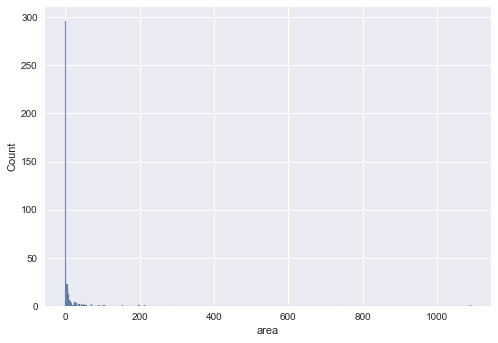

In [6]:
sns.histplot(x='area', data=df)
plt.show()

#### Transforming Target Column to Binary (0 = no fire, 1 = there's fire)

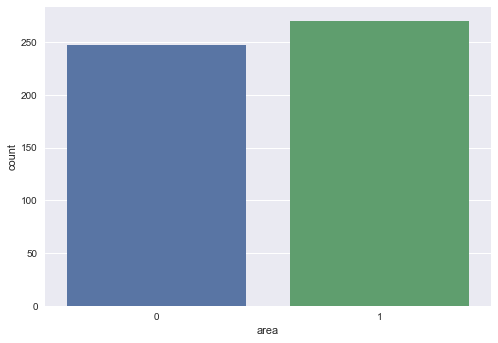

In [3]:
df['area'] = df.area.apply(lambda x: 1 if x > 0 else 0)
sns.countplot(x='area', data=df)
plt.show()

**Observations:**
- Now the target columns is **balanced**

### Define Feature Columns

In [4]:
feature_cols = df.drop(['area'], axis=1).columns.to_list()
num_cols = df[feature_cols].select_dtypes(include=['int64', 'float64']).columns.to_list()
cat_cols = list(set(feature_cols) - set(num_cols))

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

Numeric columns: ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']
Categorical columns: ['month', 'day']


### Numeric Columns

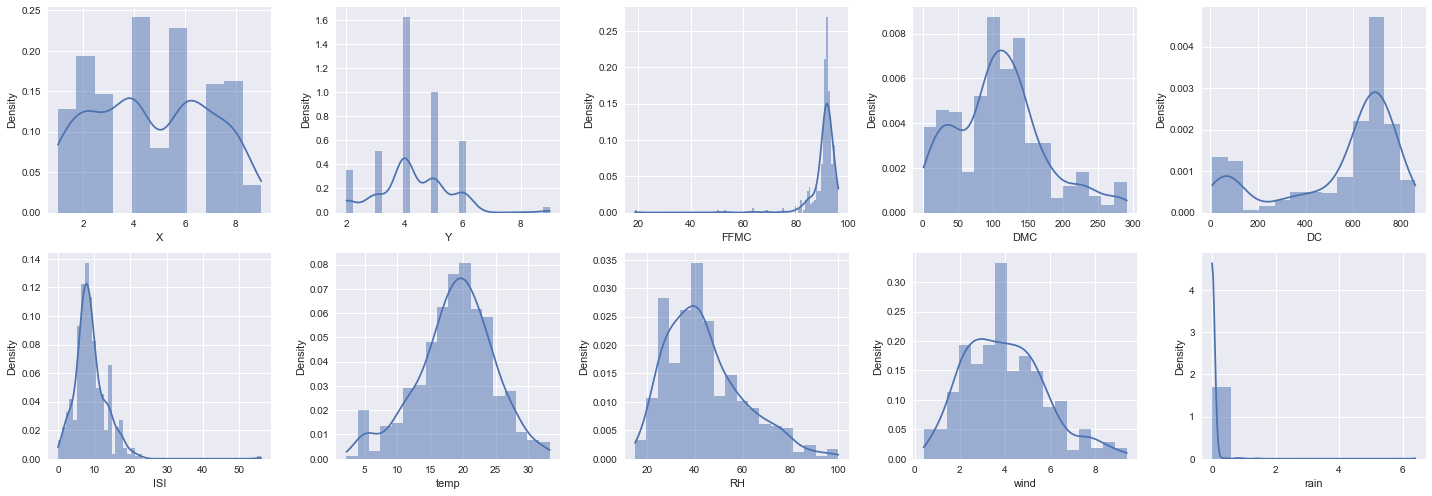

In [9]:
fig, axes = plt.subplots(nrows=2,ncols=5, figsize=(20, 7))

for i, col in enumerate(num_cols):
    sns.histplot(x=col, data=df, ax=axes[i//5, i%5], kde=True, stat="density", linewidth=0)
plt.tight_layout()
plt.show()

**Observations:**
- FFMC, DC are very left skewed.
- DMC, ISI, RH are very right skewed.

### Categorical Columns

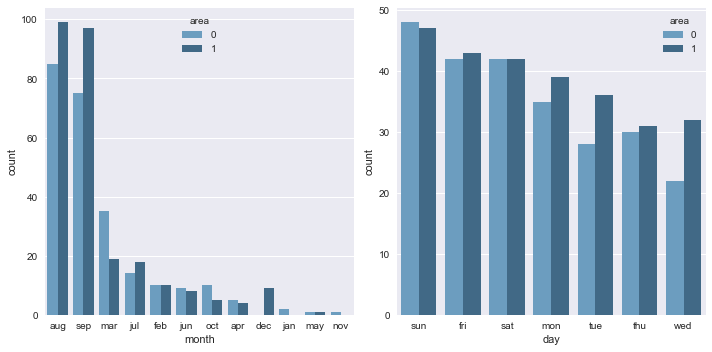

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

for i, col in enumerate(cat_cols):
    sns.countplot(
        x=col, data=df, ax=ax[i], order=df[col].value_counts().index.to_list(), palette="Blues_d", hue="area"
    )
plt.tight_layout()
plt.show()

**Observations:**
- Most of the forest fires happends on August and September.
- Based on days, it's mostly happends on Sunday.

### Checking Outliers

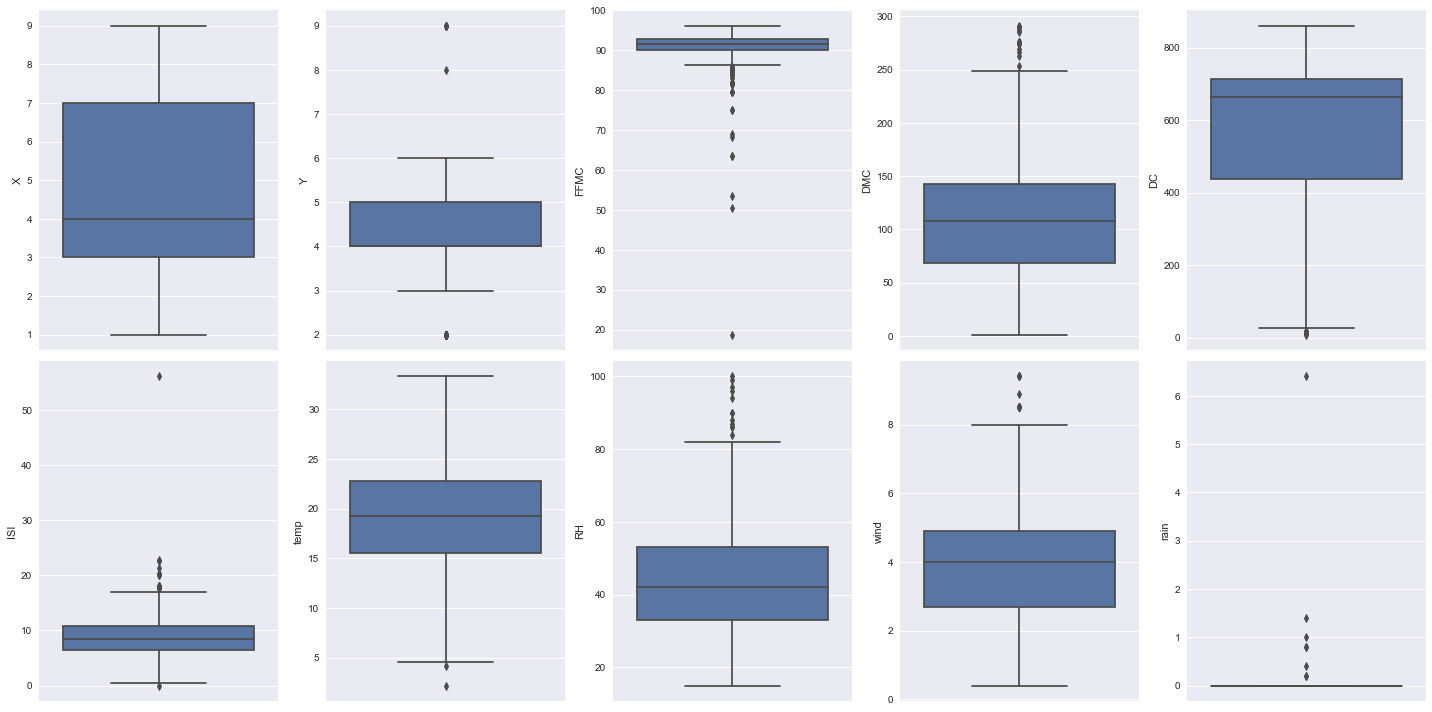

In [11]:
fig, axes = plt.subplots(nrows=2,ncols=5, figsize=(20, 10))

for i, col in enumerate(num_cols):
    sns.boxplot(y=col, data=df, ax=axes[i//5, i%5])
plt.tight_layout()
plt.show()

**Observations:**
- There might be some outliers in columns like FFMC, ISI, rain.

#### Detecting Outlier using Z-score

In [5]:
outliers_cols = list(set(num_cols) - {"X", "Y"})

In [6]:
dfz = df[outliers_cols].copy().add_prefix("z_")
dfz = dfz.apply(lambda x: (x - x.mean()) / x.std())
dfz.head()

,z_DC,z_RH,z_FFMC,z_ISI,z_DMC,z_wind,z_temp,z_rain
0,-1.828706,0.411326,-0.805180,-0.860113,-1.322045,1.497164,-1.840857,-0.073197
1,0.488418,-0.691786,-0.008094,-0.509195,-1.178399,-1.740070,-0.153130,-0.073197
2,0.560173,-0.691786,-0.008094,-0.509195,-1.048806,-1.516813,-0.738668,-0.073197
3,-1.896429,3.230391,0.191177,-0.004751,-1.211188,-0.009824,-1.823636,0.602572
4,-1.796859,3.352959,-0.243597,0.126843,-0.930142,-1.237741,-1.289763,-0.073197


In [7]:
outliers_index = []

for col in outliers_cols:
    outliers_index.extend(dfz[np.abs(dfz["z_" + col]) > 3].index.to_list())
    
outliers_index = list(set(outliers_index))
print(outliers_index)

[130, 3, 4, 12, 22, 411, 168, 299, 304, 312, 199, 211, 469, 475, 97, 243, 499, 379, 509]


#### Droping Outliers

In [8]:
df.drop(outliers_index, axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)
df.shape

(498, 13)

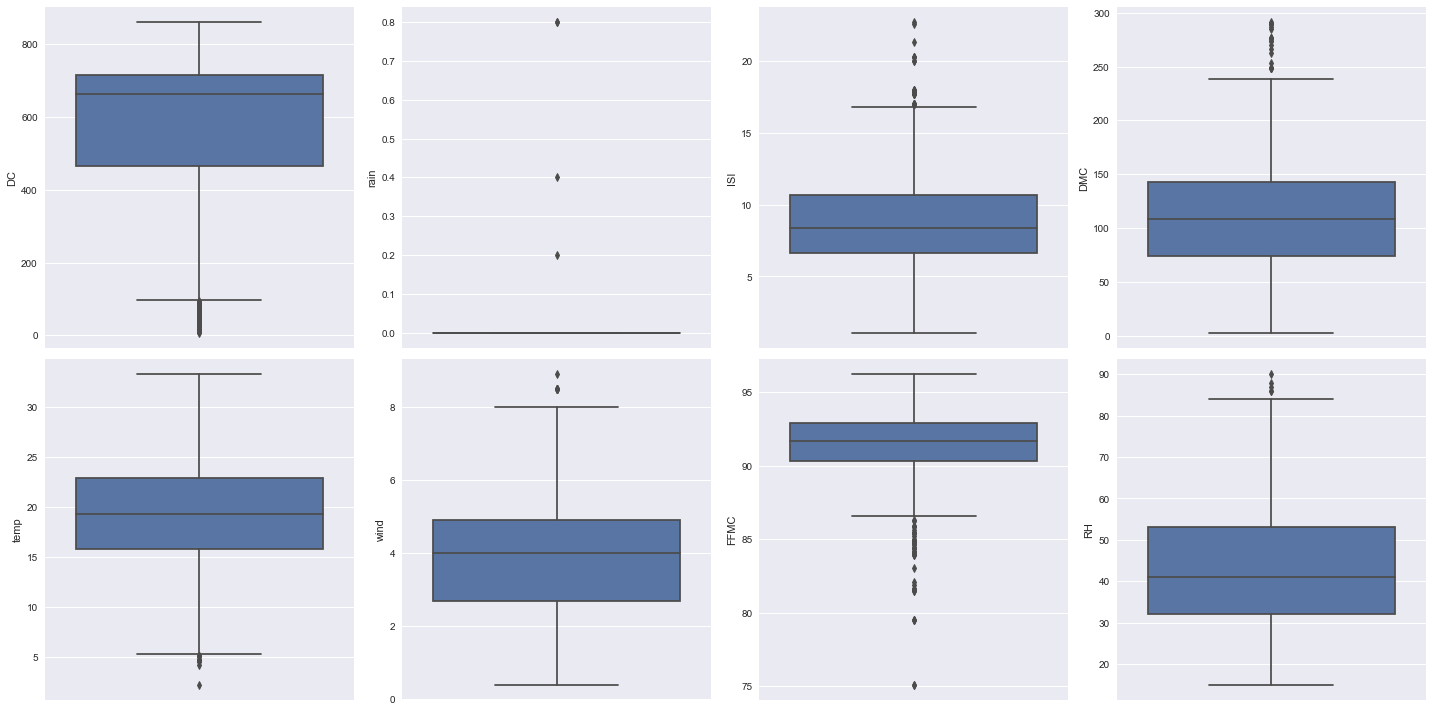

In [16]:
fig, axes = plt.subplots(nrows=2,ncols=4, figsize=(20, 10))

for i, col in enumerate(outliers_cols):
    sns.boxplot(y=col, data=df, ax=axes[i//4, i%4])
plt.tight_layout()
plt.show()

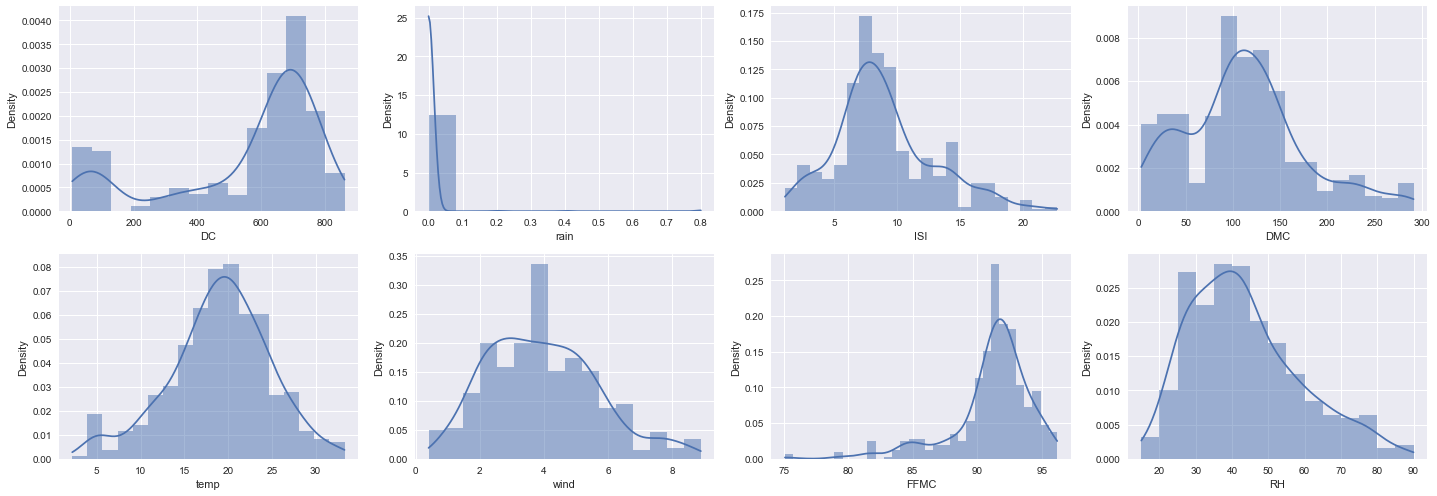

In [17]:
fig, axes = plt.subplots(nrows=2,ncols=4, figsize=(20, 7))

for i, col in enumerate(outliers_cols):
    sns.histplot(x=col, data=df, ax=axes[i//4, i%4], kde=True, stat="density", linewidth=0)
plt.tight_layout()
plt.show()

### Visualizing Correlation

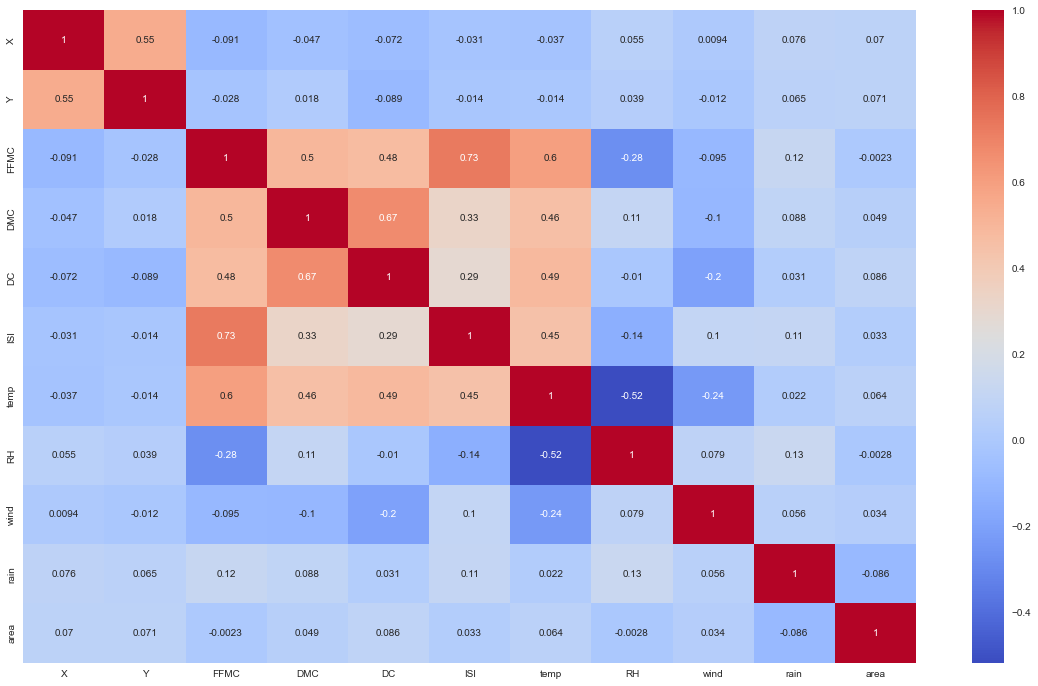

In [18]:
plt.subplots(figsize=(20, 12))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

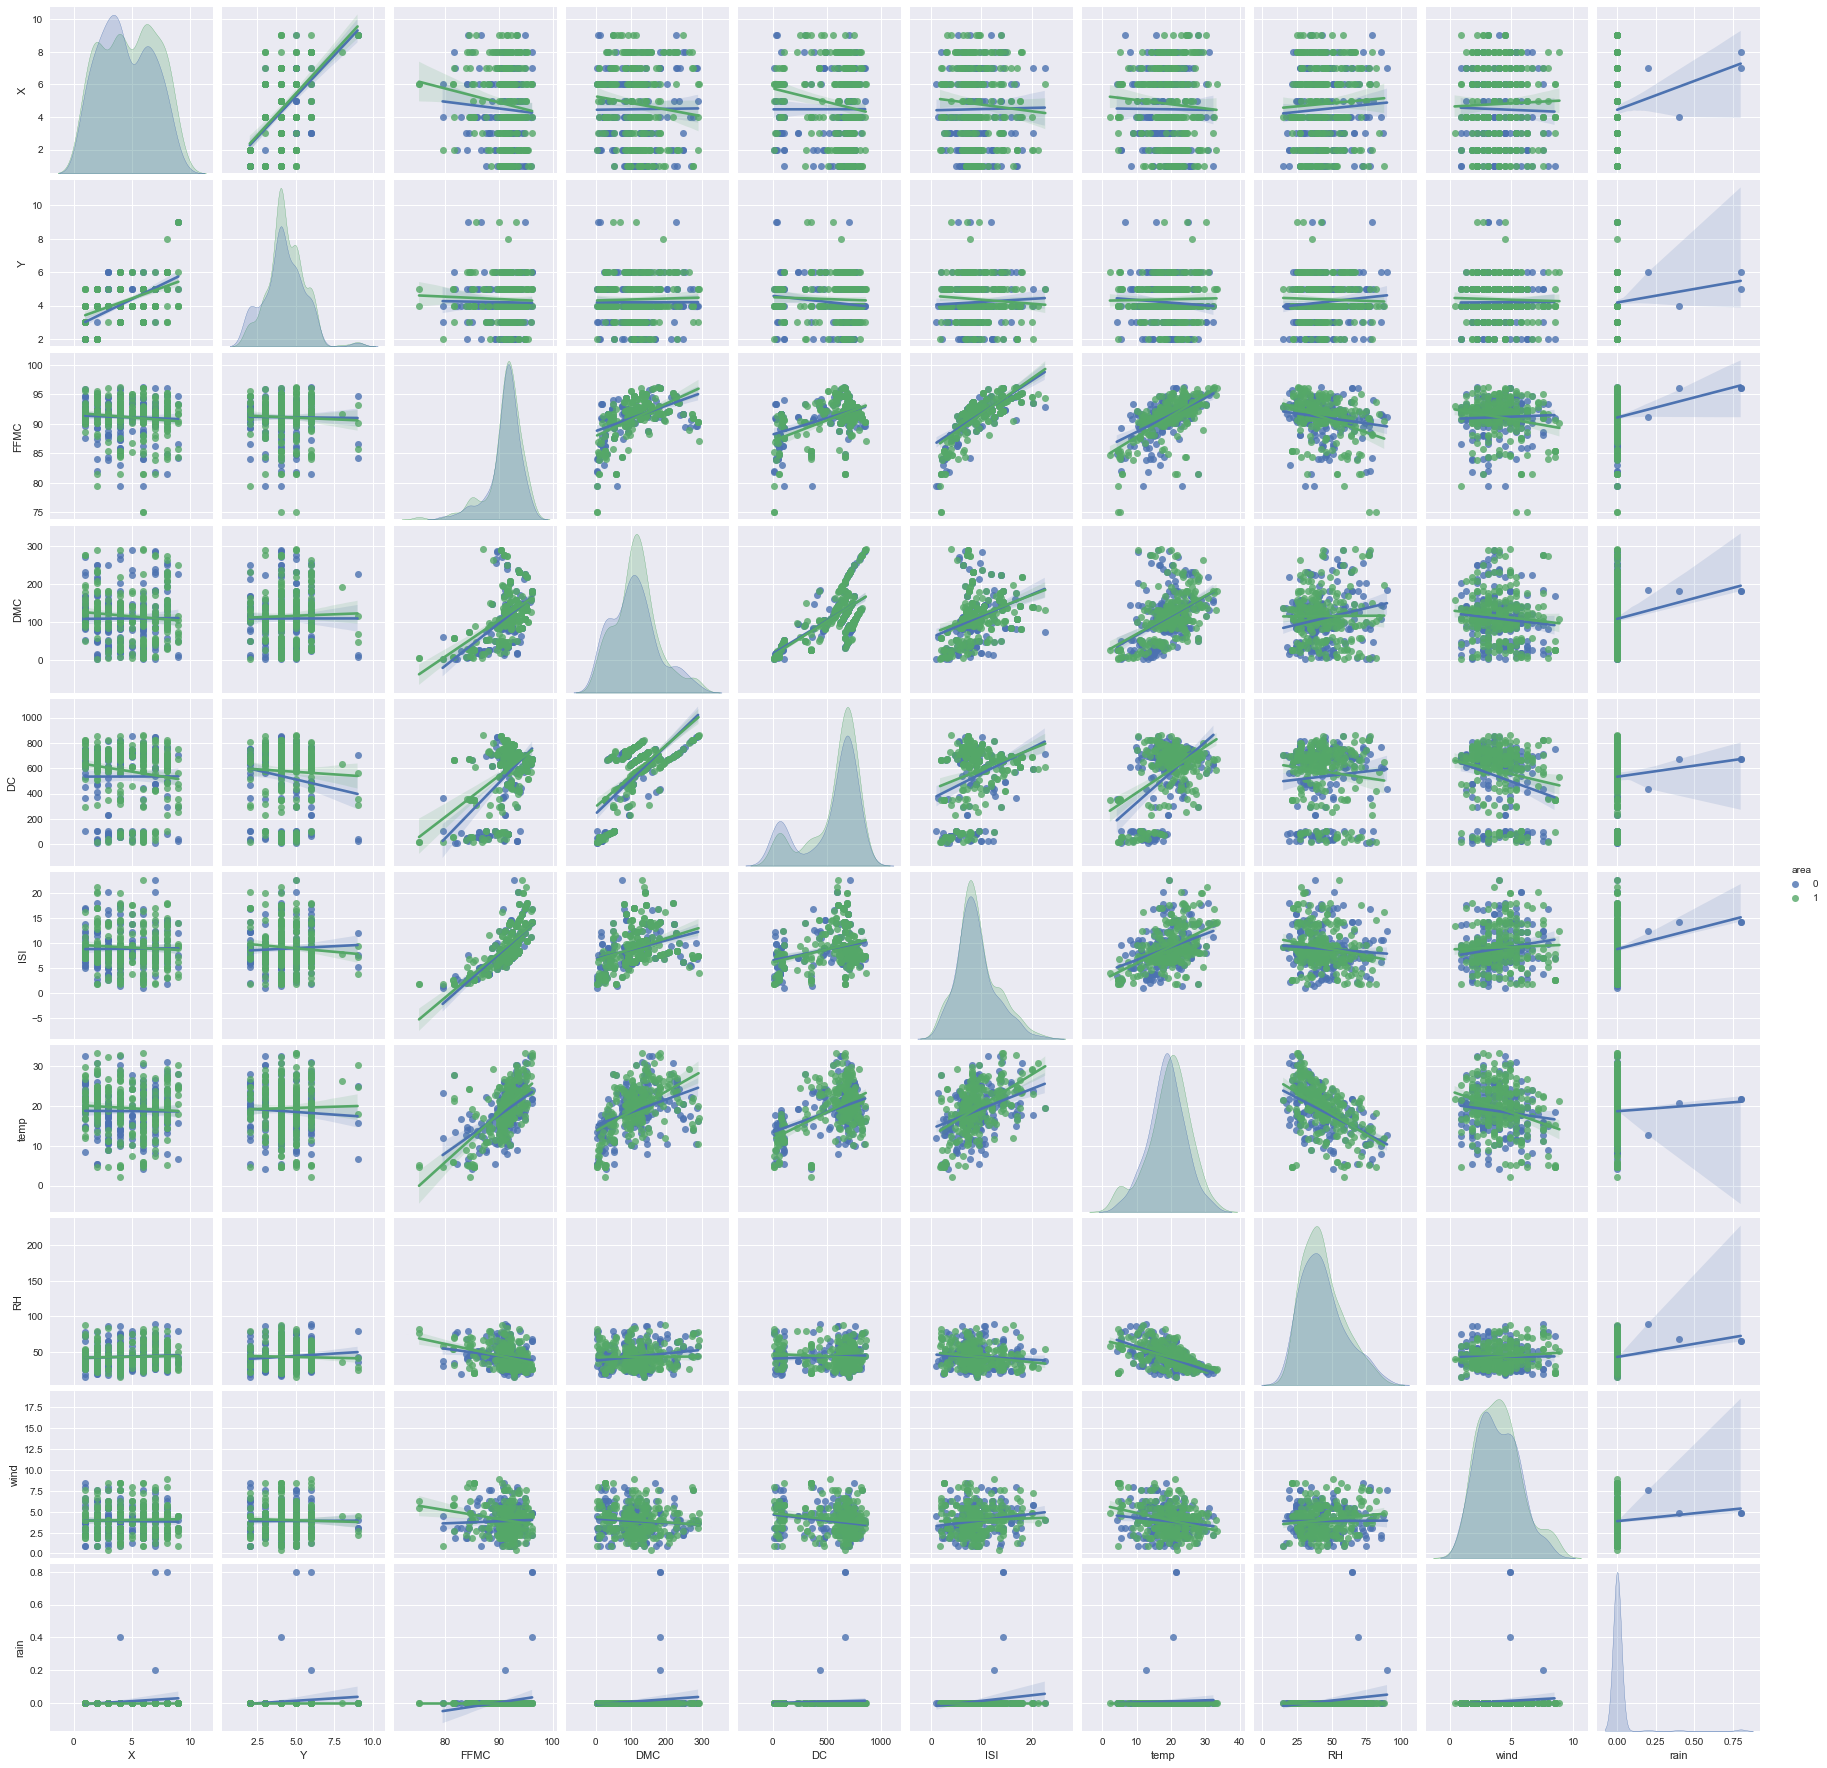

In [19]:
sns.pairplot(df[num_cols + ['area']], kind='reg', hue='area')
plt.show()

## Data Preprocessing

In [9]:
for col in cat_cols:
    dummies = pd.get_dummies(df[col])
    df = pd.concat([df, dummies], axis=1)
    df.drop([col], axis=1, inplace=True)
df.head()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,nov,oct,sep,fri,mon,sat,sun,thu,tue,wed
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,0,0,0,1,0,0,0,0,0,0
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,0,1,0,0,0,0,0,0,1,0
2,7,4,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,...,0,1,0,0,0,1,0,0,0,0
3,8,6,92.3,85.3,488.0,14.7,22.2,29,5.4,0.0,...,0,0,0,0,0,0,1,0,0,0
4,8,6,92.3,88.9,495.6,8.5,24.1,27,3.1,0.0,...,0,0,0,0,1,0,0,0,0,0


### Prepare data

In [10]:
X = df.drop(['area'], axis=1)
y = df['area']

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (498, 29)
y shape: (498,)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (398, 29)
X_test shape: (100, 29)
y_train shape: (398,)
y_test shape: (100,)


### Normalize Numeric Columns

In [12]:
scaler = StandardScaler()

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

X_train.head()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,nov,oct,sep,fri,mon,sat,sun,thu,tue,wed
56,-1.184070,-1.938551,-0.653853,-0.975881,-1.869019,0.122027,-1.360201,-0.291731,1.070105,-0.076793,...,0,0,0,0,0,0,1,0,0,0
227,-1.184070,-1.938551,0.413908,0.138960,0.492992,-0.133992,-0.167504,0.176181,-1.255957,-0.076793,...,0,0,1,0,0,1,0,0,0,0
280,-1.184070,0.585582,0.113601,-0.130966,-0.330533,-0.031584,-0.078496,0.644092,-1.255957,-0.076793,...,0,0,0,0,0,1,0,0,0,0
485,-1.184070,-0.255796,1.081259,0.431246,0.553673,2.784630,1.790656,-0.893331,0.546741,-0.076793,...,0,0,0,0,0,0,0,0,0,1
220,1.463458,1.426959,0.313806,-0.488737,-0.306179,0.710872,-0.487930,-0.024353,0.023378,-0.076793,...,0,0,0,0,0,1,0,0,0,0


In [13]:
y_train.head()

56     0
227    1
280    0
485    1
220    1
Name: area, dtype: int64

## Modeling

### First Experiment Model

In [161]:
def plot_history(history):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

    ax[0].plot(history.history["loss"], label="loss")
    ax[0].plot(history.history["val_loss"], label="val_loss")
    ax[0].set_title("Loss")
    ax[0].set_xlabel("Epochs")
    ax[0].legend()

    ax[1].plot(history.history["accuracy"], label="accuracy")
    ax[1].plot(history.history["val_accuracy"], label="val_accuracy")
    ax[1].set_title("Accuracy")
    ax[1].set_xlabel("Epochs")
    ax[1].legend()
    plt.show()

In [165]:
def eval_model(model, X_train, y_train, X_test, y_test):
    _, train_acc = model.evaluate(X_train, y_train, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Train: {train_acc:.3f}, Test: {test_acc:.3f}")

In [167]:
def model1():
    return tf.keras.Sequential([
        layers.Dense(24, input_dim=29, activation='relu', kernel_initializer='he_normal'),
        layers.Dense(1, activation='sigmoid')
    ])

In [168]:
first_model = model1()
first_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
first_model.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_166 (Dense)           (None, 24)                720       
                                                                 
 dense_167 (Dense)           (None, 1)                 25        
                                                                 
Total params: 745
Trainable params: 745
Non-trainable params: 0
_________________________________________________________________


In [169]:
history = first_model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
13/13 [==============================] - 0s 16ms/step - loss: 0.7814 - accuracy: 0.4975 - val_loss: 0.8814 - val_accuracy: 0.5200
Epoch 2/100
13/13 [==============================] - 0s 9ms/step - loss: 0.7586 - accuracy: 0.5176 - val_loss: 0.8619 - val_accuracy: 0.5100
Epoch 3/100
13/13 [==============================] - 0s 8ms/step - loss: 0.7385 - accuracy: 0.5452 - val_loss: 0.8432 - val_accuracy: 0.4700
Epoch 4/100
13/13 [==============================] - 0s 7ms/step - loss: 0.7249 - accuracy: 0.5528 - val_loss: 0.8275 - val_accuracy: 0.4900
Epoch 5/100
13/13 [==============================] - 0s 7ms/step - loss: 0.7142 - accuracy: 0.5477 - val_loss: 0.8146 - val_accuracy: 0.4800
Epoch 6/100
13/13 [==============================] - 0s 9ms/step - loss: 0.7044 - accuracy: 0.5578 - val_loss: 0.8008 - val_accuracy: 0.4600
Epoch 7/100
13/13 [==============================] - 0s 7ms/step - loss: 0.6984 - accuracy: 0.5578 - val_loss: 0.7896 - val_accuracy: 0.4600
Epoch 8/100


In [170]:
eval_model(first_model, X_train, y_train, X_test, y_test)

Train: 0.724, Test: 0.530


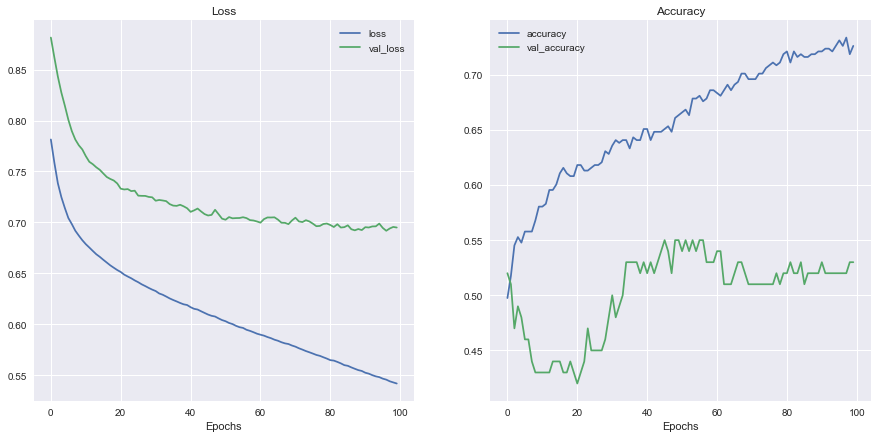

In [171]:
plot_history(history)

### Second Experiment Model

In [172]:
def model2():
    return tf.keras.Sequential([
        layers.Dense(16, input_dim=29, activation='relu', kernel_initializer='he_normal'),
        layers.Dense(32, activation='relu', kernel_initializer='he_normal'),
        layers.Dense(1, activation='sigmoid')
    ])

In [173]:
second_model = model2()
second_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
second_model.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_168 (Dense)           (None, 16)                480       
                                                                 
 dense_169 (Dense)           (None, 32)                544       
                                                                 
 dense_170 (Dense)           (None, 1)                 33        
                                                                 
Total params: 1,057
Trainable params: 1,057
Non-trainable params: 0
_________________________________________________________________


In [174]:
history = second_model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
13/13 [==============================] - 1s 21ms/step - loss: 0.7446 - accuracy: 0.5050 - val_loss: 0.7072 - val_accuracy: 0.5600
Epoch 2/100
13/13 [==============================] - 0s 8ms/step - loss: 0.7068 - accuracy: 0.4975 - val_loss: 0.7098 - val_accuracy: 0.4900
Epoch 3/100
13/13 [==============================] - 0s 7ms/step - loss: 0.6940 - accuracy: 0.5201 - val_loss: 0.7139 - val_accuracy: 0.5100
Epoch 4/100
13/13 [==============================] - 0s 7ms/step - loss: 0.6878 - accuracy: 0.5276 - val_loss: 0.7116 - val_accuracy: 0.5200
Epoch 5/100
13/13 [==============================] - 0s 8ms/step - loss: 0.6807 - accuracy: 0.5327 - val_loss: 0.7036 - val_accuracy: 0.4800
Epoch 6/100
13/13 [==============================] - 0s 6ms/step - loss: 0.6747 - accuracy: 0.5553 - val_loss: 0.6992 - val_accuracy: 0.5000
Epoch 7/100
13/13 [==============================] - 0s 7ms/step - loss: 0.6696 - accuracy: 0.5653 - val_loss: 0.6991 - val_accuracy: 0.5200
Epoch 8/100


In [175]:
eval_model(second_model, X_train, y_train, X_test, y_test)

Train: 0.837, Test: 0.660


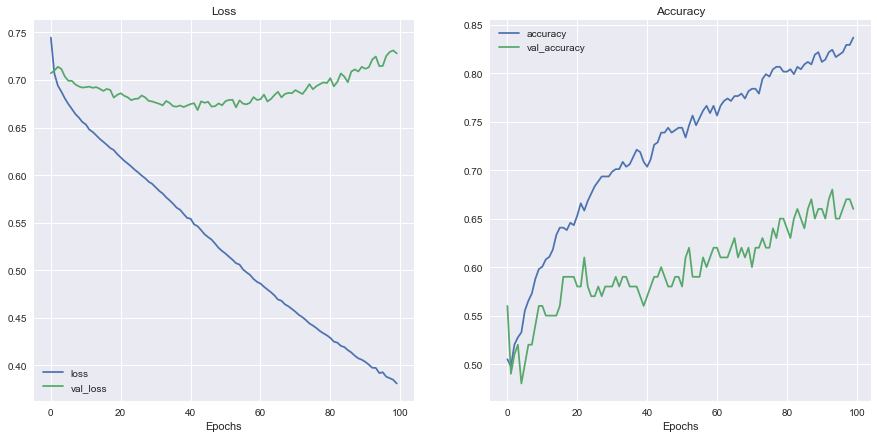

In [176]:
plot_history(history)

### Third Experiment Model

In [196]:
def model3():
    return tf.keras.Sequential([
        layers.Dense(16, input_dim=29, activation='relu', kernel_initializer='he_normal'),
        layers.Dense(32, activation='relu', kernel_initializer='he_normal'),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
        layers.Dense(1, activation='sigmoid')
    ])

In [201]:
third_model = model3()
third_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
third_model.summary()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_186 (Dense)           (None, 16)                480       
                                                                 
 dense_187 (Dense)           (None, 32)                544       
                                                                 
 dropout_27 (Dropout)        (None, 32)                0         
                                                                 
 dense_188 (Dense)           (None, 64)                2112      
                                                                 
 dense_189 (Dense)           (None, 1)                 65        
                                                                 
Total params: 3,201
Trainable params: 3,201
Non-trainable params: 0
_________________________________________________________________


In [202]:
history = third_model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
13/13 [==============================] - 1s 21ms/step - loss: 0.7829 - accuracy: 0.4824 - val_loss: 0.7341 - val_accuracy: 0.5300
Epoch 2/100
13/13 [==============================] - 0s 6ms/step - loss: 0.7109 - accuracy: 0.5503 - val_loss: 0.7388 - val_accuracy: 0.5200
Epoch 3/100
13/13 [==============================] - 0s 6ms/step - loss: 0.6983 - accuracy: 0.5251 - val_loss: 0.7320 - val_accuracy: 0.5300
Epoch 4/100
13/13 [==============================] - 0s 7ms/step - loss: 0.7006 - accuracy: 0.5327 - val_loss: 0.7191 - val_accuracy: 0.5400
Epoch 5/100
13/13 [==============================] - 0s 7ms/step - loss: 0.6975 - accuracy: 0.5402 - val_loss: 0.7127 - val_accuracy: 0.5200
Epoch 6/100
13/13 [==============================] - 0s 7ms/step - loss: 0.6839 - accuracy: 0.5528 - val_loss: 0.7142 - val_accuracy: 0.4900
Epoch 7/100
13/13 [==============================] - 0s 6ms/step - loss: 0.6997 - accuracy: 0.5427 - val_loss: 0.7130 - val_accuracy: 0.4700
Epoch 8/100


In [203]:
eval_model(third_model, X_train, y_train, X_test, y_test)

Train: 0.819, Test: 0.610


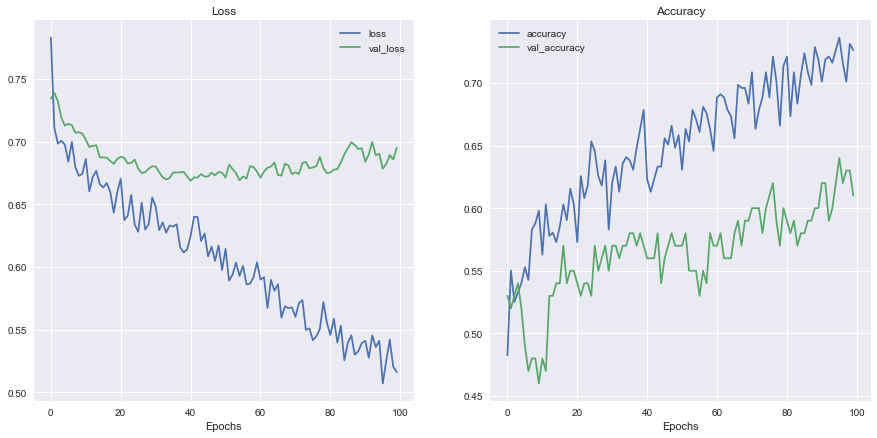

In [204]:
plot_history(history)

### **Observations:**
- Second and Third model is decent although the test score is still far away from the train score.
- I'll pick **second model** since it has the best test score and the graph is quite fit.

### Defining Experiment Model

In [246]:
def experiment_model(
    X_train,
    y_train,
    X_test,
    y_test,
    batch_size=32,
    optimizer=Adam,
    lr=0.001,
    epochs=100,
    initializer="he_normal",
    loss="binary_crossentropy",
    hidden_activation="relu",
):
    # define model
    model = tf.keras.Sequential(
        [
            layers.Dense(
                16,
                input_dim=29,
                activation=hidden_activation,
                kernel_initializer=initializer,
            ),
            layers.Dense(
                32, activation=hidden_activation, kernel_initializer=initializer
            ),
            layers.Dense(1, activation="sigmoid"),
        ]
    )

    # compile model
    model.compile(
        loss=loss,
        optimizer=optimizer(learning_rate=lr),
        metrics=["accuracy"],
    )

    # fit model
    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        verbose=0,
        batch_size=batch_size,
    )

    # plot learning curves
    plt.plot(history.history["accuracy"], label="train")
    plt.plot(history.history["val_accuracy"], label="test")
    plt.title(
        f"lr={lr}, batch={batch_size}, epochs={epochs}, init={initializer}, opt={optimizer.__name__}, loss={loss}, hidden_activation={hidden_activation}",
        fontsize=9,
    )
    plt.legend()

### Batch Sizes Experiments

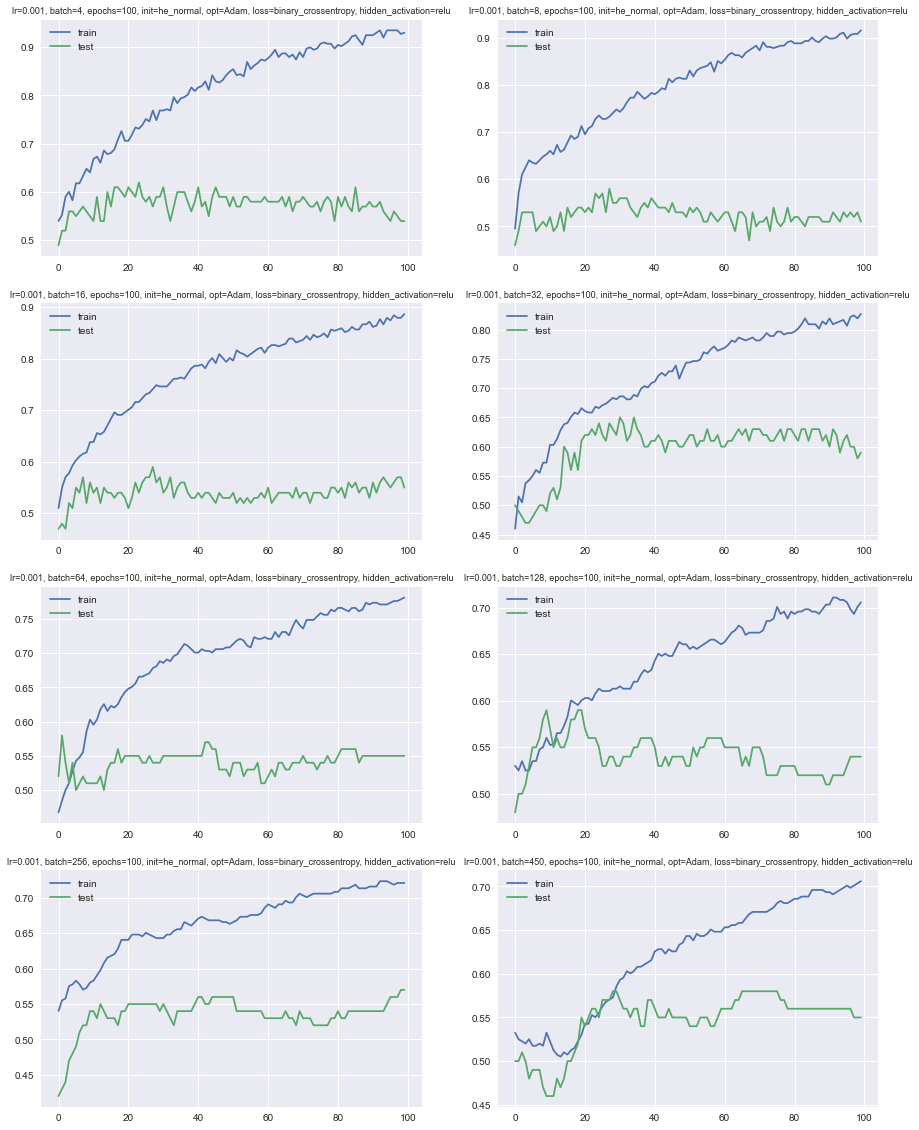

In [221]:
batch_sizes = [4, 8, 16, 32, 64, 128, 256, 450]

plt.figure(figsize=(15, 20))
for i, batch_size in enumerate(batch_sizes):
    # determine the plot number
    plot_no = 420 + (i + 1)
    plt.subplot(plot_no)
    
    experiment_model(X_train, y_train, X_test, y_test, batch_size=batch_size)
    plt.title(f"Batch size: {batch_size}", fontsize=14)
plt.show()

**Observations:**
- **Batch size 32** is the best amongst all the batch sizes

### Optimizer Experiments

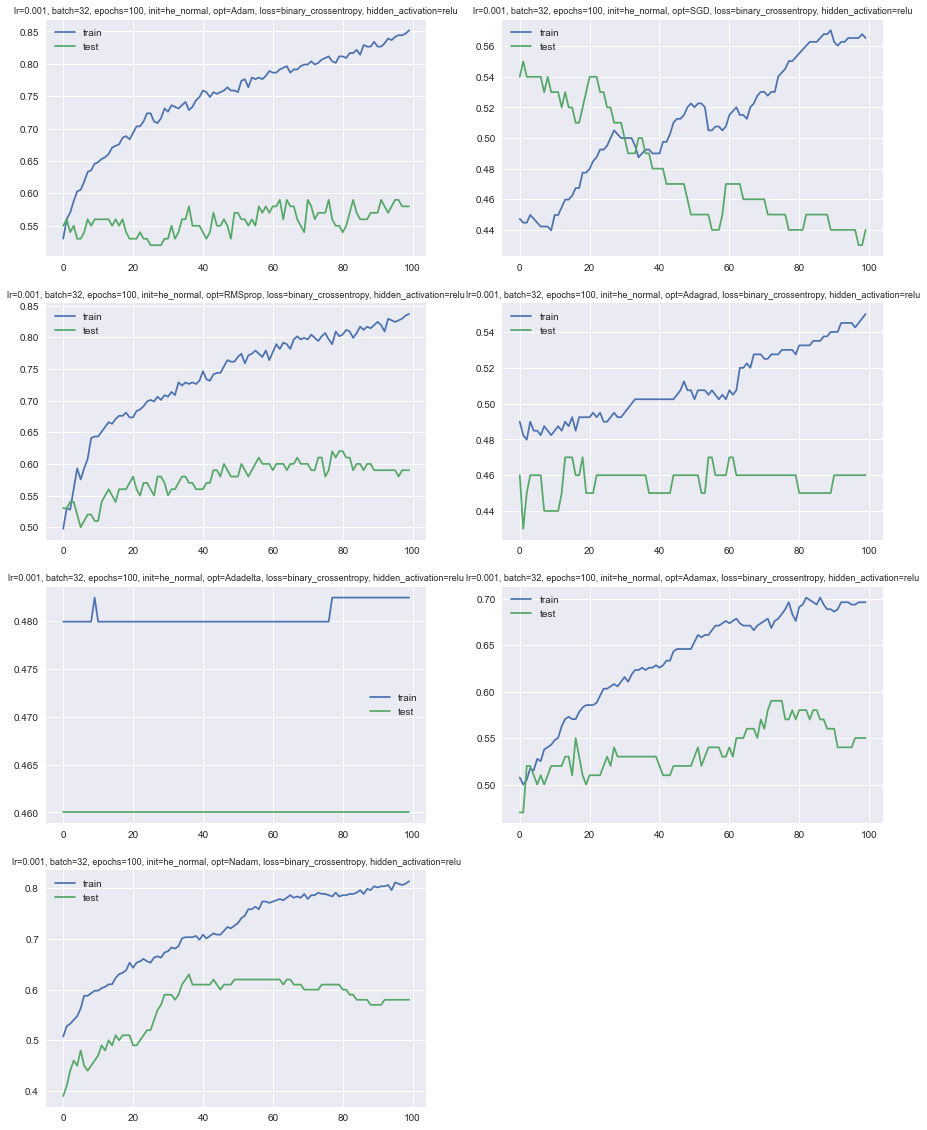

In [226]:
opts = [Adam, SGD, RMSprop, Adagrad, Adadelta, Adamax, Nadam]

plt.figure(figsize=(15, 20))
for i, opt in enumerate(opts):
    # determine the plot number
    plot_no = 420 + (i + 1)
    plt.subplot(plot_no)
    
    experiment_model(X_train, y_train, X_test, y_test, batch_size=32, optimizer=opt)
    plt.title(opt.__name__, fontsize=14)
plt.show()

**Observations:**
- Adam, RMSprop, and Nadam are the best 3 out off the rest
- Let's try to train with them more to pick the best optimizer

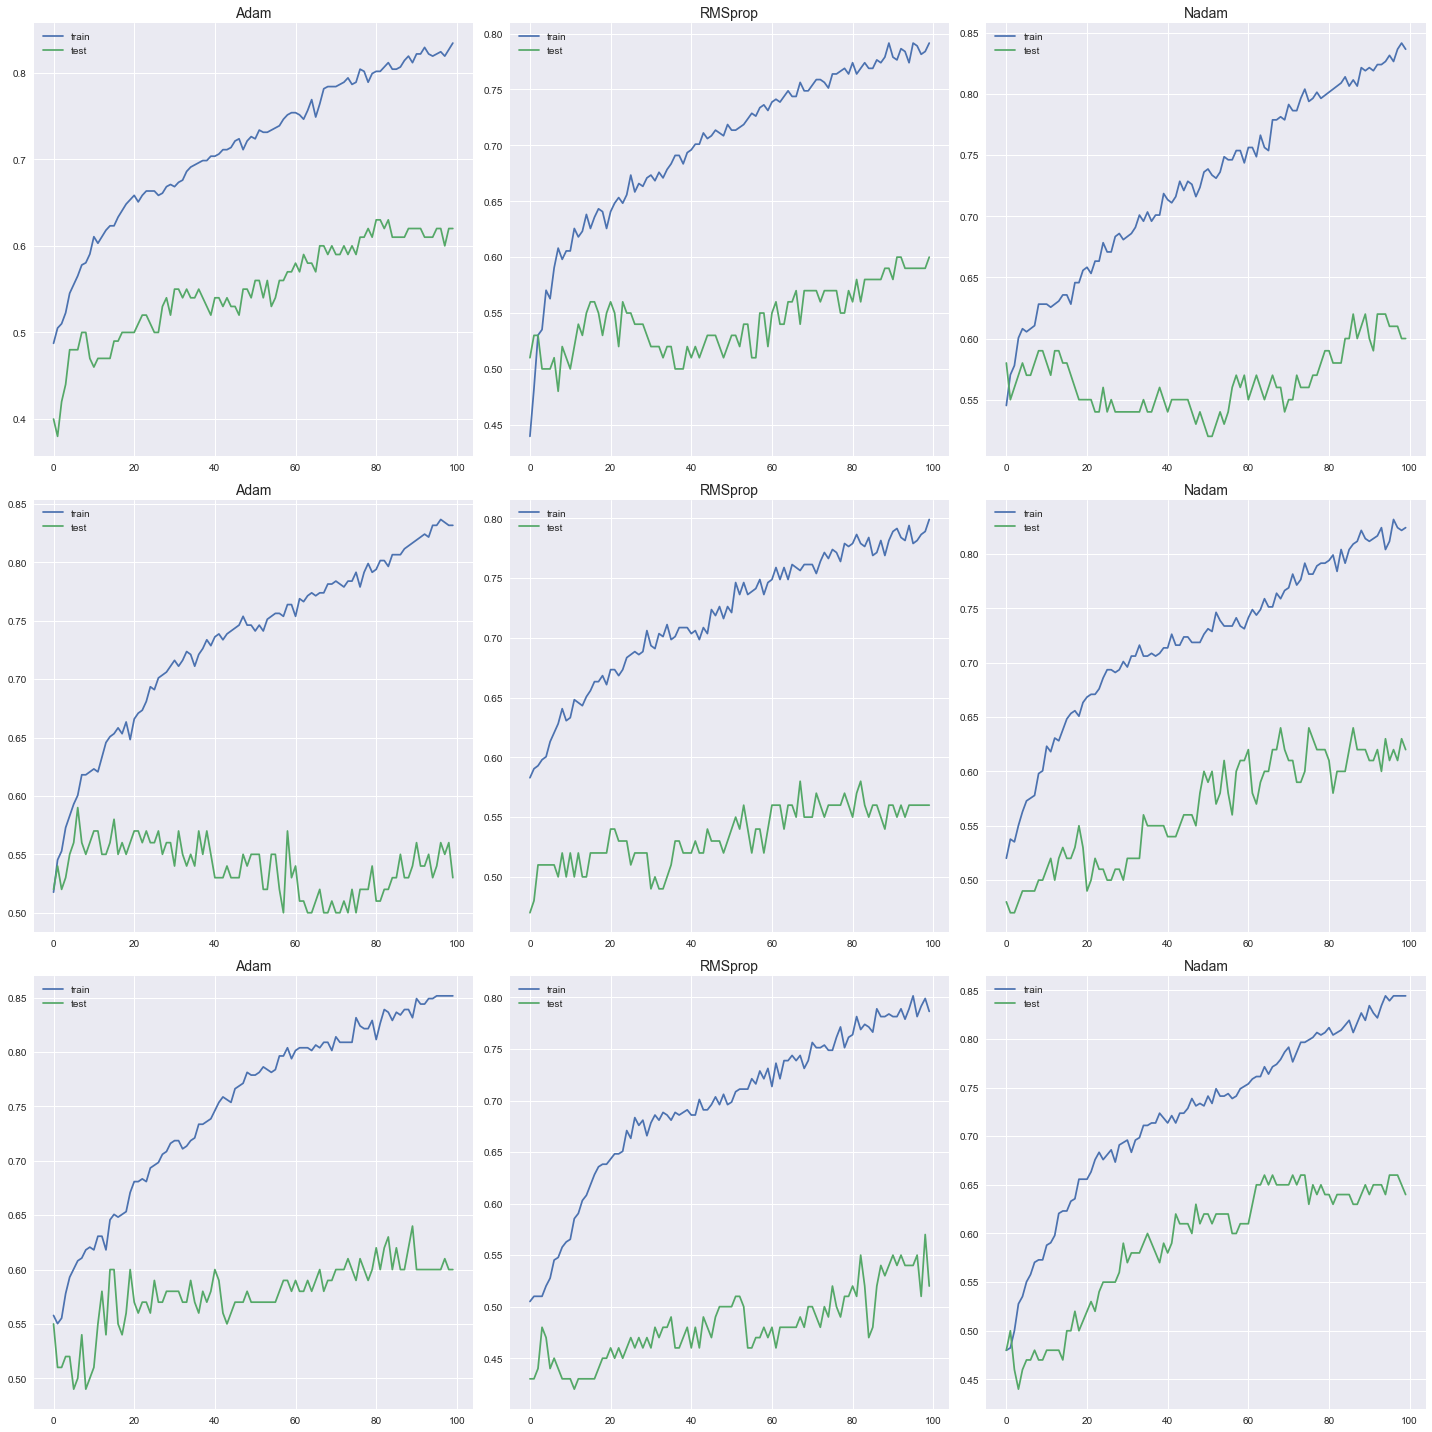

In [232]:
opts = [Adam, RMSprop, Nadam]

plt.figure(figsize=(20, 20))
for i, opt in enumerate(opts):
    for j in range(3):
        # determine the plot number
        plot_no = 330 + (i + 1) + (3 * j)
        plt.subplot(plot_no)
        experiment_model(X_train, y_train, X_test, y_test, batch_size=32, optimizer=opt, epochs=100)
        plt.title(f"{opt.__name__}", fontsize=14)
plt.tight_layout()
plt.show()

**Observations:**
- In the 3 iterations, Nadam is the most consistent optimizer to reach the highest scores
- I'll pick **Nadam**.

### Learning Rate Experiments

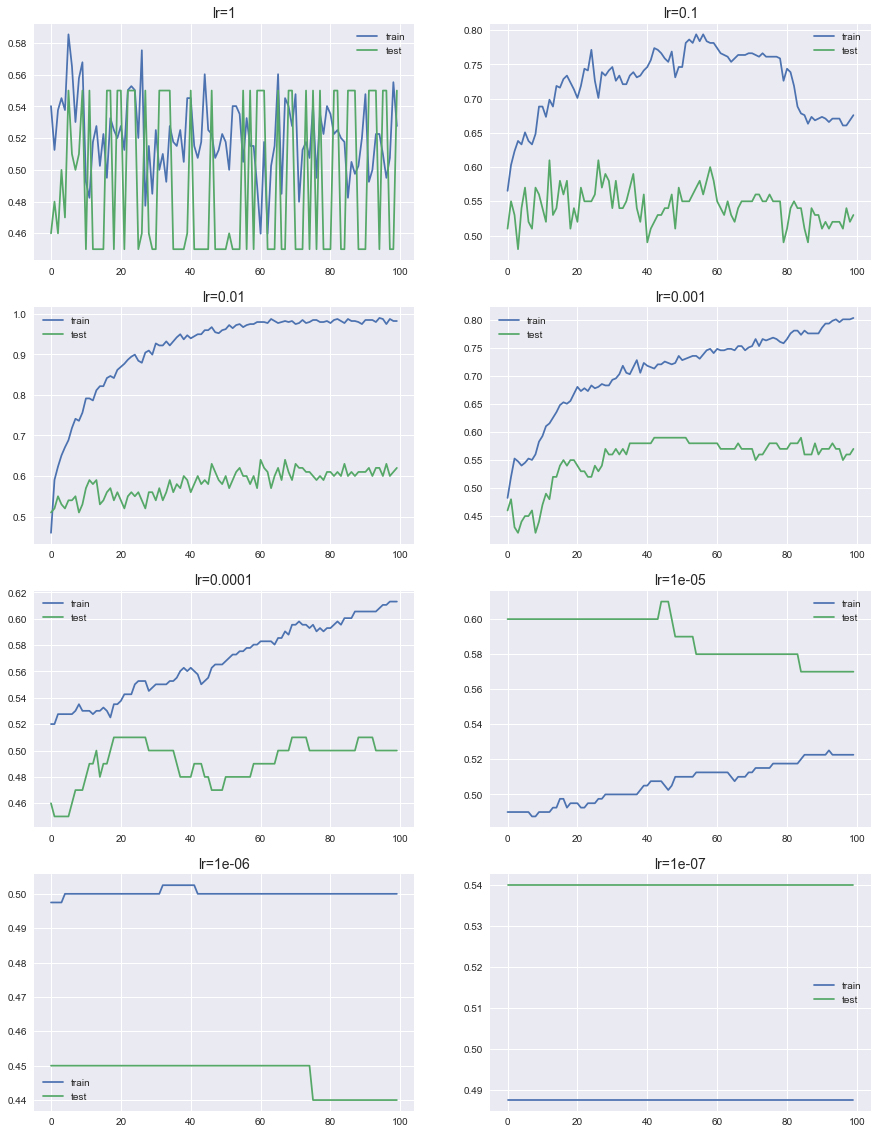

In [238]:
lrs = [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]

plt.figure(figsize=(15, 20))
for i, lr in enumerate(lrs):
    # determine the plot number
    plot_no = 420 + (i + 1)
    plt.subplot(plot_no)

    experiment_model(X_train, y_train, X_test, y_test, batch_size=32, optimizer=Nadam, lr=lr)
    plt.title(f"lr={lr}", fontsize=14)
plt.show()


**Observations:**
- **0.01** is the best learning rate

### Epochs Experiments

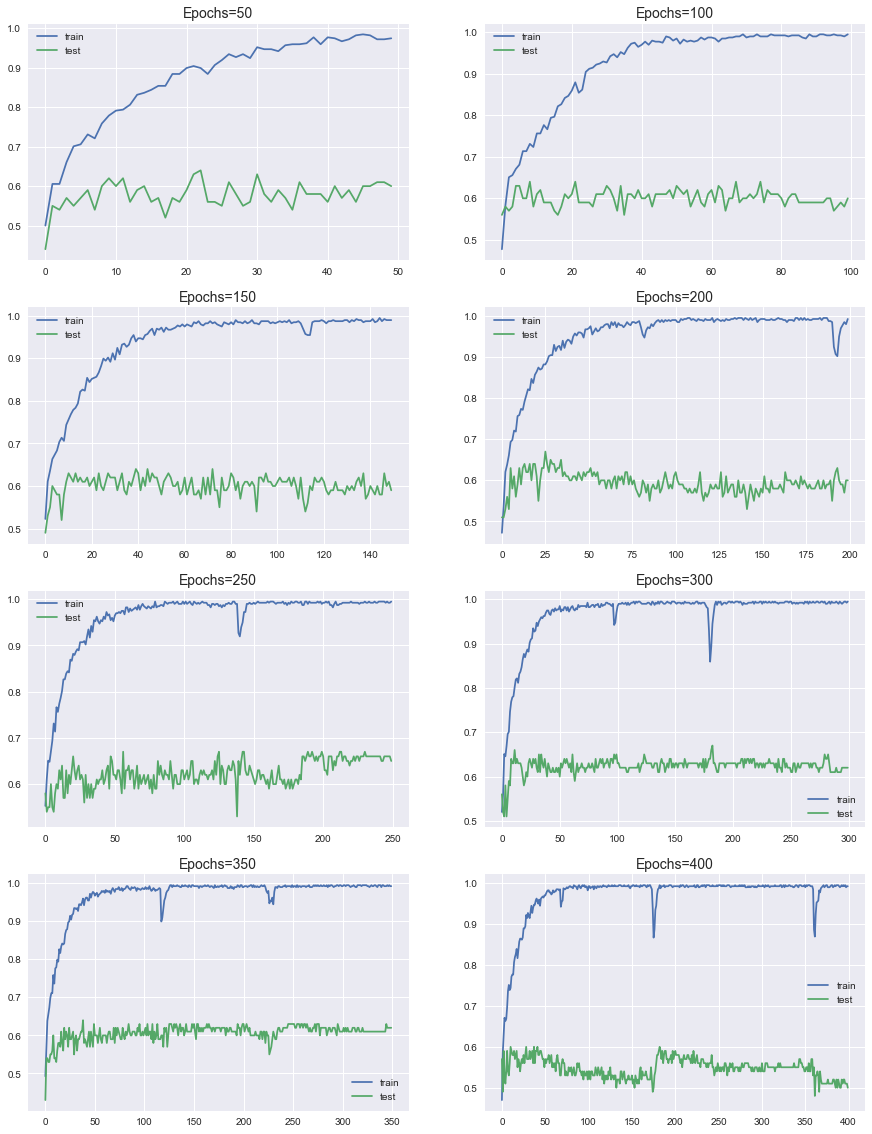

In [239]:
epochs = [50, 100, 150, 200, 250, 300, 350, 400]

plt.figure(figsize=(15, 20))
for i, epoch in enumerate(epochs):
    # determine the plot number
    plot_no = 420 + (i + 1)
    plt.subplot(plot_no)

    experiment_model(
        X_train,
        y_train,
        X_test,
        y_test,
        batch_size=32,
        optimizer=Nadam,
        lr=0.01,
        epochs=epoch,
    )
    plt.title(f"Epochs={epoch}", fontsize=14)
plt.show()


**Observations:**
- I'll pick epochs=250 because it seems to have improvement.

### Initializer Experiments

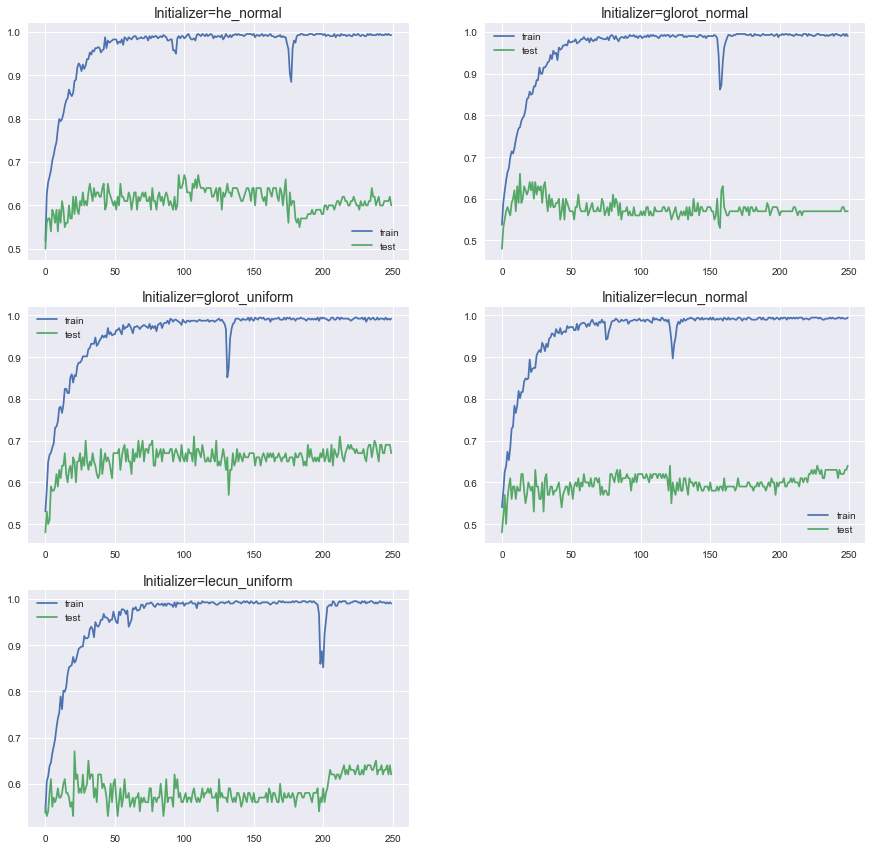

In [240]:
initializer = [
    "he_normal",
    "glorot_normal",
    "glorot_uniform",
    "lecun_normal",
    "lecun_uniform",
]

plt.figure(figsize=(15, 20))
for i, init in enumerate(initializer):
    # determine the plot number
    plot_no = 420 + (i + 1)
    plt.subplot(plot_no)

    experiment_model(
        X_train,
        y_train,
        X_test,
        y_test,
        batch_size=32,
        optimizer=Nadam,
        lr=0.01,
        epochs=250,
        initializer=init,
    )
    plt.title(f"Initializer={init}", fontsize=14)
plt.show()


**Observations:**
- It's obvious that **glorot_uniform** scores the highest, almost 0.7
- I'll pick **glorot_uniform**

### Loss function Experiments

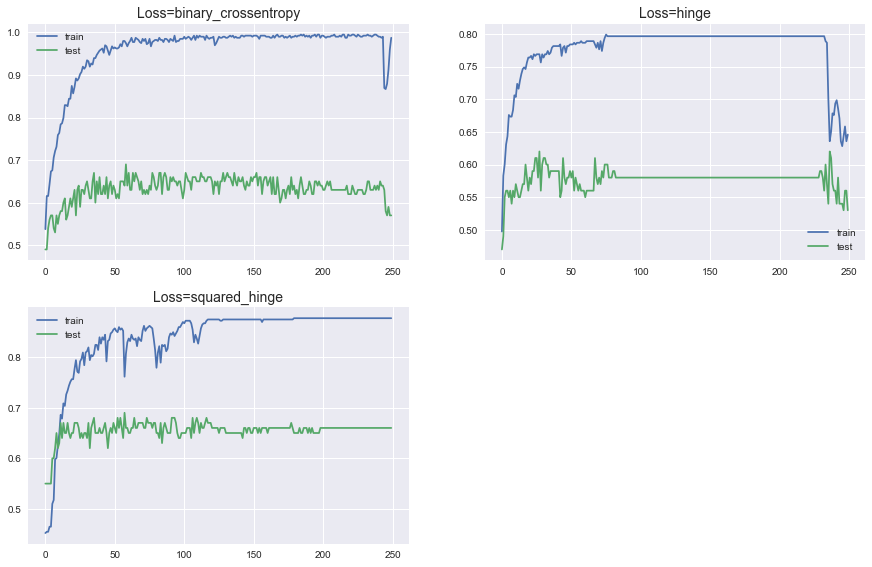

In [242]:
loss_functions = ["binary_crossentropy", "hinge", "squared_hinge"]

plt.figure(figsize=(15, 20))
for i, loss in enumerate(loss_functions):
    # determine the plot number
    plot_no = 420 + (i + 1)
    plt.subplot(plot_no)

    experiment_model(
        X_train,
        y_train,
        X_test,
        y_test,
        batch_size=32,
        optimizer=Nadam,
        lr=0.01,
        epochs=250,
        initializer="glorot_uniform",
        loss=loss,
    )
    plt.title(f"Loss={loss}", fontsize=14)


**Observations:**
- **squared_hinge** achieves a higher and more stable score. 
- I'll pick **squared_hinge**

### Hidden Layer Activation Function Experiments

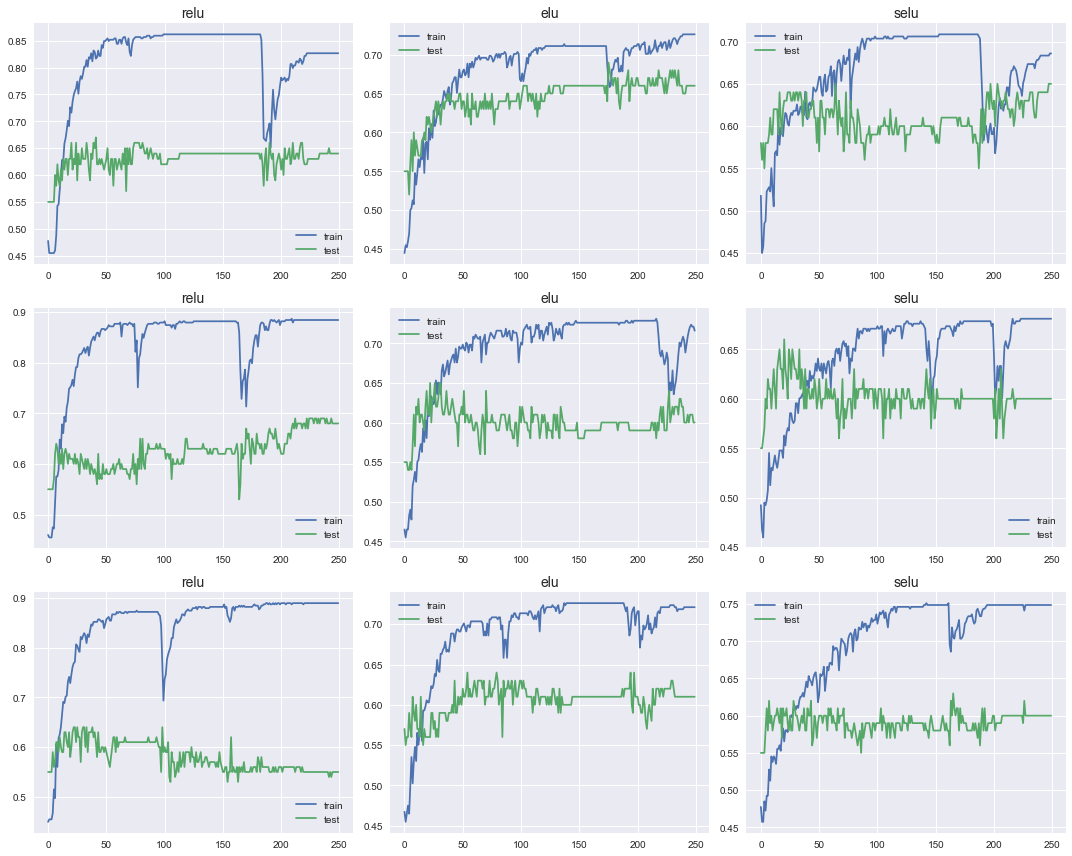

In [253]:
activations = ["relu", "elu", "selu"]

plt.figure(figsize=(15, 12))
for i, activation in enumerate(activations):
    for j in range(3):
        # determine the plot number
        plot_no = 330 + (i + 1) + (3 * j)
        plt.subplot(plot_no)

        experiment_model(
            X_train,
            y_train,
            X_test,
            y_test,
            batch_size=32,
            optimizer=Nadam,
            lr=0.01,
            epochs=250,
            initializer="glorot_uniform",
            loss="squared_hinge",
            hidden_activation=activation,
        )
        plt.title(f"{activation}", fontsize=14)
plt.tight_layout()
plt.show()

**Observations:**
- I think I'll pick **relu** because atleast the train score is good. The scores difference also not so obvious between all the functions.

## Final Model

### Before Dropout

In [305]:
model = tf.keras.Sequential(
    [
        layers.Dense(
            16,
            input_dim=29,
            activation="relu",
            kernel_initializer="glorot_uniform",
        ),
        layers.Dense(32, activation="relu", kernel_initializer="glorot_uniform"),
        layers.Dense(1, activation="sigmoid"),
    ]
)

# compile model
model.compile(
    loss="squared_hinge",
    optimizer=Nadam(learning_rate=0.01),
    metrics=["accuracy"],
)

es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=150)
mc = ModelCheckpoint('checkpoints/best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# fit model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=250,
    verbose=1,
    batch_size=32,
    callbacks=[es, mc],
)

Epoch 1/250
11/13 [========================>.....] - ETA: 0s - loss: 1.0843 - accuracy: 0.4716
Epoch 1: val_accuracy improved from -inf to 0.55000, saving model to checkpoints\best_model.h5
13/13 [==============================] - 1s 26ms/step - loss: 1.0855 - accuracy: 0.4749 - val_loss: 1.1003 - val_accuracy: 0.5500
Epoch 2/250
10/13 [======================>.......] - ETA: 0s - loss: 1.0072 - accuracy: 0.4750
Epoch 2: val_accuracy did not improve from 0.55000
13/13 [==============================] - 0s 15ms/step - loss: 0.9930 - accuracy: 0.4548 - val_loss: 1.0492 - val_accuracy: 0.5500
Epoch 3/250
 9/13 [===================>..........] - ETA: 0s - loss: 0.9781 - accuracy: 0.4826
Epoch 3: val_accuracy did not improve from 0.55000
13/13 [==============================] - 0s 10ms/step - loss: 0.9690 - accuracy: 0.4548 - val_loss: 1.0524 - val_accuracy: 0.5500
Epoch 4/250
 9/13 [===================>..........] - ETA: 0s - loss: 0.9459 - accuracy: 0.4514
Epoch 4: val_accuracy did not imp

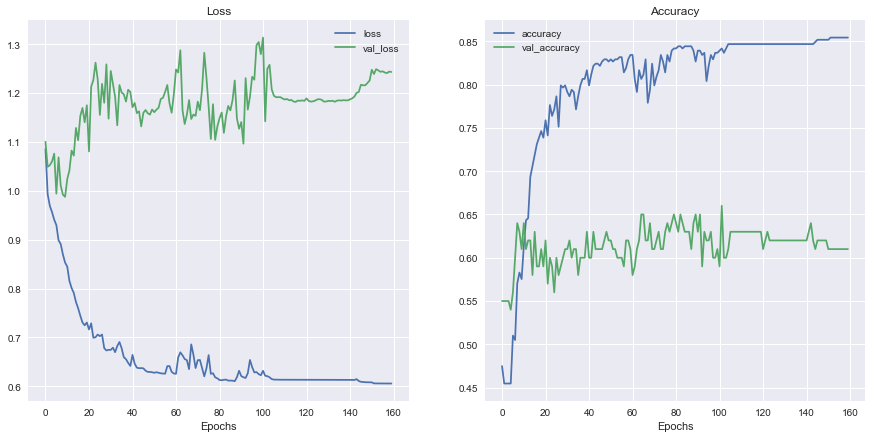

In [306]:
plot_history(history)

In [307]:
eval_model(model, X_train, y_train, X_test, y_test)

Train: 0.854, Test: 0.610


In [308]:
saved_model = load_model('checkpoints/best_model.h5')
eval_model(saved_model, X_train, y_train, X_test, y_test)

Train: 0.839, Test: 0.660


### Adding Dropout Experiment

In [332]:
model2 = tf.keras.Sequential(
    [
        layers.Dense(
            16,
            input_dim=29,
            activation="relu",
            kernel_initializer="glorot_uniform",
        ),
        layers.Dropout(0.2),
        layers.Dense(32, activation="relu", kernel_initializer="glorot_uniform"),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ]
)

# compile model
model2.compile(
    loss="squared_hinge",
    optimizer=Nadam(learning_rate=0.01),
    metrics=["accuracy"],
)

es2 = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=150)
mc2 = ModelCheckpoint(
    "checkpoints/best_model2.h5",
    monitor="val_accuracy",
    mode="max",
    verbose=1,
    save_best_only=True,
)

# fit model
history2 = model2.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=250,
    verbose=1,
    batch_size=32,
    callbacks=[es2, mc2],
)


Epoch 1/250
11/13 [========================>.....] - ETA: 0s - loss: 1.0708 - accuracy: 0.4716
Epoch 1: val_accuracy improved from -inf to 0.55000, saving model to checkpoints\best_model2.h5
13/13 [==============================] - 1s 26ms/step - loss: 1.0613 - accuracy: 0.4623 - val_loss: 1.1098 - val_accuracy: 0.5500
Epoch 2/250
 9/13 [===================>..........] - ETA: 0s - loss: 0.9858 - accuracy: 0.4653
Epoch 2: val_accuracy did not improve from 0.55000
13/13 [==============================] - 0s 10ms/step - loss: 0.9913 - accuracy: 0.4548 - val_loss: 1.0578 - val_accuracy: 0.5500
Epoch 3/250
 8/13 [=================>............] - ETA: 0s - loss: 0.9734 - accuracy: 0.4531
Epoch 3: val_accuracy did not improve from 0.55000
13/13 [==============================] - 0s 11ms/step - loss: 0.9772 - accuracy: 0.4548 - val_loss: 1.0435 - val_accuracy: 0.5500
Epoch 4/250
 6/13 [============>.................] - ETA: 0s - loss: 0.9702 - accuracy: 0.4688
Epoch 4: val_accuracy did not im

In [333]:
eval_model(model2, X_train, y_train, X_test, y_test)

Train: 0.837, Test: 0.660


In [343]:
saved_model2 = load_model('checkpoints/best_model2.h5')
eval_model(saved_model2, X_train, y_train, X_test, y_test)

Train: 0.804, Test: 0.710


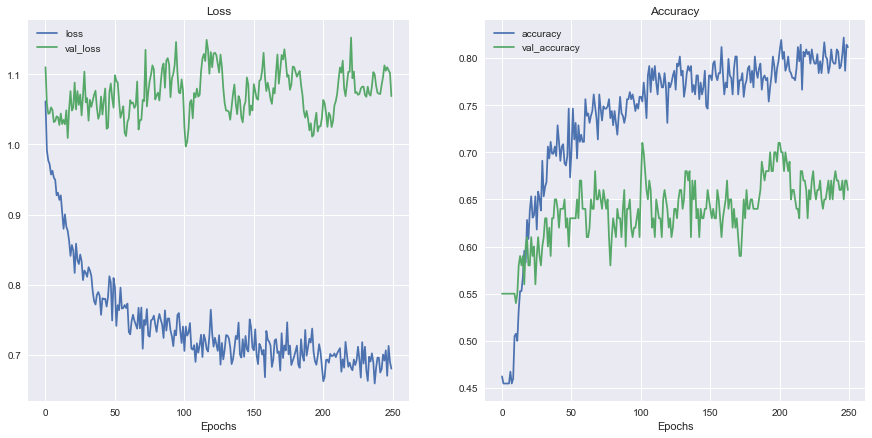

In [344]:
plot_history(history2)

### Conclution:
- Adding dropout makes the accuracy better since it reduces the chance to overfit the model
- The Best Test Score is **0.71 (which is not good enough)**
- Our model is not good enough to predict Forest Fire Estimation from this dataset, since it has been through a lot of experiments and its score is also not good enough.
- I think the problem is not the model, but the data itself. We can see that the features have very low correlation with the target. They might have a lot of noises too.

In [345]:
predictions = saved_model2.predict(X_test)
predictions = (predictions > 0.5).astype(int)
predictions[:5]

4/4 [==============================] - 0s 1ms/step


array([[0],
       [0],
       [0],
       [0],
       [1]])

In [346]:
y_test.head()

487    1
73     0
231    0
175    1
237    1
Name: area, dtype: int64